In [ ]:
# import readdy
import boto3
import numpy as np
import argparse

In [ ]:
s3 = boto3.client('s3')
response = s3.download_file('readdy-working-bucket', 'outputs/actin_compression_velocity=15_0.h5', 'actin_compression_velocity=15_0.h5')

In [ ]:
cd ..

In [ ]:
from subcell_analysis.readdy import (
    ReaddyLoader,
    ReaddyPostProcessor,
)

h5_file_path = 'notebooks/actin_compression_velocity=15_0.h5'


post_processor = ReaddyPostProcessor(
    ReaddyLoader(h5_file_path).trajectory(),
    box_size=600.0 * np.ones(3),
)
fiber_chain_ids = post_processor.linear_fiber_chain_ids(
    start_particle_phrases=["pointed"],
    other_particle_types=[
        "actin#",
        "actin#ATP_",
        "actin#mid_",
        "actin#mid_ATP_",
        "actin#fixed_",
        "actin#fixed_ATP_",
        "actin#mid_fixed_",
        "actin#mid_fixed_ATP_",
        "actin#barbed_",
        "actin#barbed_ATP_",
        "actin#fixed_barbed_",
        "actin#fixed_barbed_ATP_",
    ],
    polymer_number_range=5,
)
axis_positions, _ = post_processor.linear_fiber_axis_positions(
    fiber_chain_ids=fiber_chain_ids,
    ideal_positions=np.array(
        [
            [24.738, 20.881, 26.671],
            [27.609, 24.061, 27.598],
            [30.382, 21.190, 25.725],
        ]
    ),
    ideal_vector_to_axis=np.array(
        [-0.01056751, -1.47785105, -0.65833209],
    ),
)
fiber_points = post_processor.linear_fiber_control_points(
    axis_positions=axis_positions,
    segment_length=10.0,
)
print(fiber_points)

In [27]:
from subcell_analysis.compression_workflow_runner import run_workflow,  plot_metric, plot_metric_list
from subcell_analysis.compression_analysis import (
    COMPRESSIONMETRIC,
)
from subcell_analysis.cytosim.post_process_cytosim import create_dataframes_for_repeats
import pandas as pd


In [ ]:
arr = np.array(fiber_points)
arr.shape


def array_to_dataframe(arr):
    # Reshape the array to remove the singleton dimensions
    arr = np.squeeze(arr)

    # Reshape the array to have dimensions (timepoints * 50, 3)
    reshaped_arr = arr.reshape(-1, 3)

    # Create a DataFrame with timepoint and fiber point as multi-index
    timepoints = np.repeat(range(arr.shape[0]), 50)
    fiber_points = np.tile(range(50), arr.shape[0])

    df = pd.DataFrame(reshaped_arr)
    df['time'] = timepoints
    df['id'] = fiber_points

    df.set_index(['time', 'id'], inplace=True)

    return df
df_points = array_to_dataframe(arr)
df_points.reset_index(inplace=True)
df_points.rename(columns= {0:'x', 1:'y', 2:'z'}, inplace=True)
single_timepoint = df_points[df_points['time'] == 0]
single_timepoint

In [ ]:
df_points
df_points['time'].unique()

In [ ]:
df_points[df_points["id"] == 0]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Assuming you have a DataFrame named 'df_points' with columns 'time', 'id', 'x', 'y', and 'z'
# df_points = pd.DataFrame(...)  # Your data goes here

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get unique timestamps in the data
timestamps = df_points['time'].unique()

# Function to update the plot at each time step
def update_plot(time_step, ax=ax):
    ax.cla()  # Clear previous plot

    # Filter the data for the current timestamp
    data_at_time = df_points[df_points['time'] == timestamps[time_step]]

    # Plot the points at the current time step
    ax.scatter(data_at_time['x'], data_at_time['y'], data_at_time['z'], c='r', marker='o')

    # Set plot labels and title
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_zlabel('Z Position')
    ax.set_title(f'Time: {timestamps[time_step]}')
    ax.set_xlim([-300, 300])
    ax.set_ylim([-15, 15])
    ax.set_zlim([-10, 30])
    ax.set_aspect("equal")

# Create the animation
# update_plot(-1) 
animation = FuncAnimation(fig, update_plot, frames=len(timestamps), interval=10, repeat=False)
# If you want to save the animation to a file
# animation.save('3d_animation.mp4', writer='ffmpeg')
animation.save('3d_animation_frames/frame_{:04d}.png', writer='pillow', fps=1)

# Show the plot (If you don't want to save it)
plt.show()


In [ ]:
%matplotlib inline

In [ ]:
plt.close("all")

In [ ]:
import pandas as pd

In [41]:
df_pts = pd.read_csv("dataframes/readdy_processed_data.csv")

In [42]:
df_pts

,time,id,xpos,ypos,zpos
0,0,0,-247.203989,0.005700,-0.025601
1,0,1,-237.205717,0.004532,0.000700
2,0,2,-227.207445,-0.018927,-0.003873
3,0,3,-217.209173,-0.002720,-0.010525
4,0,4,-207.210900,-0.001733,0.012359
...,...,...,...,...,...
50045,1000,45,199.162395,18.349756,-2.372898
50046,1000,46,207.324313,12.595465,-2.222143
50047,1000,47,216.012498,7.748714,-1.373433
50048,1000,48,224.980591,3.543521,-0.250379


In [39]:
df_pts = df_pts.rename(columns={"x": 'xpos', "y": 'ypos', "z": 'zpos'})

In [40]:
cols_to_drop = [col for col in df_pts.columns if 'Unnamed' in col]
df_pts = df_pts.drop(columns=cols_to_drop)
df_pts.to_csv("dataframes/readdy_processed_data.csv", index=False)

In [ ]:
from subcell_analysis.compression_workflow_runner import run_workflow
import matplotlib.pyplot as plt

In [28]:
df_pts

,Unnamed: 0,time,id,xpos,ypos,zpos,NON_COPLANARITY,PEAK_ASYMMETRY,TOTAL_FIBER_TWIST
0,0,0,0,-247.203989,0.005700,-0.025601,NaN,NaN,NaN
1,1,0,1,-237.205717,0.004532,0.000700,NaN,NaN,NaN
2,2,0,2,-227.207445,-0.018927,-0.003873,NaN,NaN,NaN
3,3,0,3,-217.209173,-0.002720,-0.010525,NaN,NaN,NaN
4,4,0,4,-207.210900,-0.001733,0.012359,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
50045,50045,1000,45,199.162395,18.349756,-2.372898,NaN,NaN,NaN
50046,50046,1000,46,207.324313,12.595465,-2.222143,NaN,NaN,NaN
50047,50047,1000,47,216.012498,7.748714,-1.373433,NaN,NaN,NaN
50048,50048,1000,48,224.980591,3.543521,-0.250379,NaN,NaN,NaN


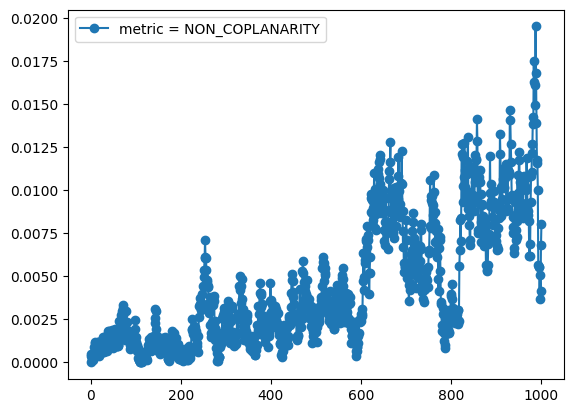

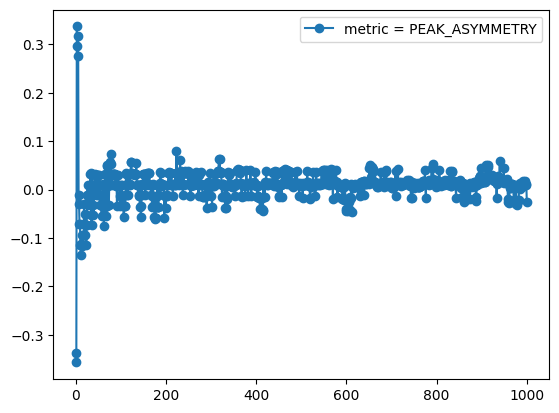

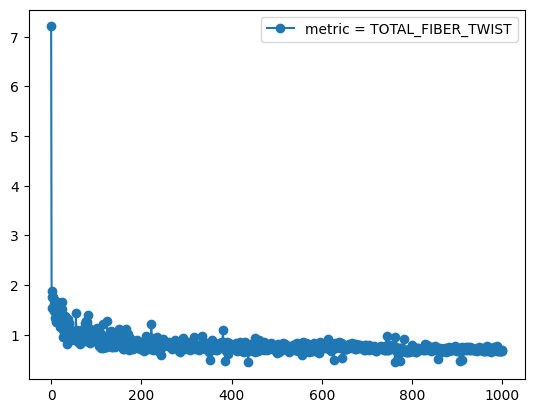

In [31]:
# df_pts = array_to_dataframe(arr).reset_index()
df_pts = df_pts.rename(columns={"x": 'xpos', "y": 'ypos', "z": 'zpos'})
metrics = [COMPRESSIONMETRIC.NON_COPLANARITY, COMPRESSIONMETRIC.PEAK_ASYMMETRY, COMPRESSIONMETRIC.TOTAL_FIBER_TWIST]
run_workflow(df_pts, [COMPRESSIONMETRIC.NON_COPLANARITY, COMPRESSIONMETRIC.PEAK_ASYMMETRY, COMPRESSIONMETRIC.TOTAL_FIBER_TWIST])
for metric in metrics:
    fig, ax = plt.subplots()
    metric_by_time = df_pts.groupby(["time"])[metric.value].mean()
    ax.plot(metric_by_time, "o-", label=f"metric = {metric.value}")
    plt.legend()
    plt.show()
    